In [16]:
import pickle
import glob


def mitm(graph):

    rule1 = {}
    rule2 = {}

    for central_node in [n for n,data in graph.nodes(data=True) if data.get("node_type") == 1]:

        for _, neighbor, edge_data in graph.edges(central_node, data=True):

            # Initialization
            if central_node not in rule1:
                rule1[central_node] = {}

            if central_node not in rule2:
                rule2[central_node] = {}

            # Path
            if "path" in edge_data["label"] :

                print(edge_data["label"])

                # Rule 1
                rule1[central_node]["path"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                # Rule 2
                rule2[central_node]["path"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

            # IP_src
            elif edge_data["label"] == "ip_src":

                rule1[central_node]["ip_src"] ={
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["ip_src"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

            # IP_dst
            elif edge_data["label"] == "ip_dst":

                rule1[central_node]["ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

    rule1 = {key:value for key, value in rule1.items() if "ip_src" in value and "path" in value}
    rule2 = {key:value for key, value in rule2.items() if "ip_dst" in value and "path" in value}

    node_matches = []
    for node1 in rule1:

        for node2 in rule2:

            if rule1[node1]["path"] == rule2[node2]["path"]:

                if rule1[node1]["ip_src"] == rule2[node2]["ip_dst"]:

                    if "ip_src" in rule2[node2]:
                        node_matches.append((node1, node2, rule1[node1]["path"]["neighbor"], rule1[node1]["ip_src"]["neighbor"], rule1[node1]["ip_dst"]["neighbor"], rule2[node2]["ip_src"]["neighbor"]))

    return node_matches


In [2]:
def uplink_spoofing(graph):
    rule1 = {}
    rule2 = {}

    for central_node in [n for n,data in graph.nodes(data=True) if data.get("node_type") == 1]:

        for _, neighbor, edge_data in graph.edges(central_node, data=True):

            # Initialization
            if central_node not in rule1:
                rule1[central_node] = {}

            if central_node not in rule2:
                rule2[central_node] = {}

            # IP_src
            if edge_data["label"] == "ip_src":

                rule1[central_node]["ip_src"] ={
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["ip_src"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

            # IP_dst
            elif edge_data["label"] == "ip_dst":

                rule1[central_node]["ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

            # GTP_IP_src
            elif "ip_src" in edge_data["label"] and "ip" in edge_data["label"]:

                rule1[central_node]["gtp_ip_src"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["gtp_ip_src"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

            # GTP_IP_dst
            elif "ip_dst" in edge_data["label"] and "ip" in edge_data["label"]:

                rule1[central_node]["gtp_ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

                rule2[central_node]["gtp_ip_dst"] = {
                    "neighbor": neighbor,
                    "value" : graph.nodes[neighbor]["label"]
                }

        node_matches = []
        for node1,_ in rule1.items():

            for node2,_ in rule2.items():

                if len(rule1[node1]) == len(rule2[node2]) == 4 :

                    rule_verif = True
                    rule_verif = rule_verif and rule1[node1]["ip_dst"] == rule2[node2]["ip_src"]
                    rule_verif = rule_verif and rule1[node1]["ip_src"] != rule2[node2]["ip_dst"]
                    rule_verif = rule_verif and rule1[node1]["gtp_ip_dst"] == rule2[node2]["gtp_ip_src"]
                    rule_verif = rule_verif and rule1[node1]["gtp_ip_src"] == rule2[node2]["gtp_ip_dst"]

                    if rule_verif:
                        node_matches.append((node1, node2, rule1[node1]["ip_src"]["neighbor"], rule1[node1]["ip_dst"]["neighbor"], rule1[node1]["gtp_ip_src"]["neighbor"], rule1[node1]["gtp_ip_dst"]["neighbor"], rule2[node2]["ip_dst"]["neighbor"]))

        return node_matches


In [17]:
mitm_matches = []
uplink_matches = []
for filepath in sorted(glob.glob("../../data/pre_process/graph_construction/*.pkl")):
    with open(filepath, 'rb') as f:
        graph = pickle.load(f)

        mitm_matches += mitm(graph)
        print(len(mitm_matches))

        # uplink_matches += uplink_spoofing(graph)
        # print(len(uplink_matches))

0
0
0


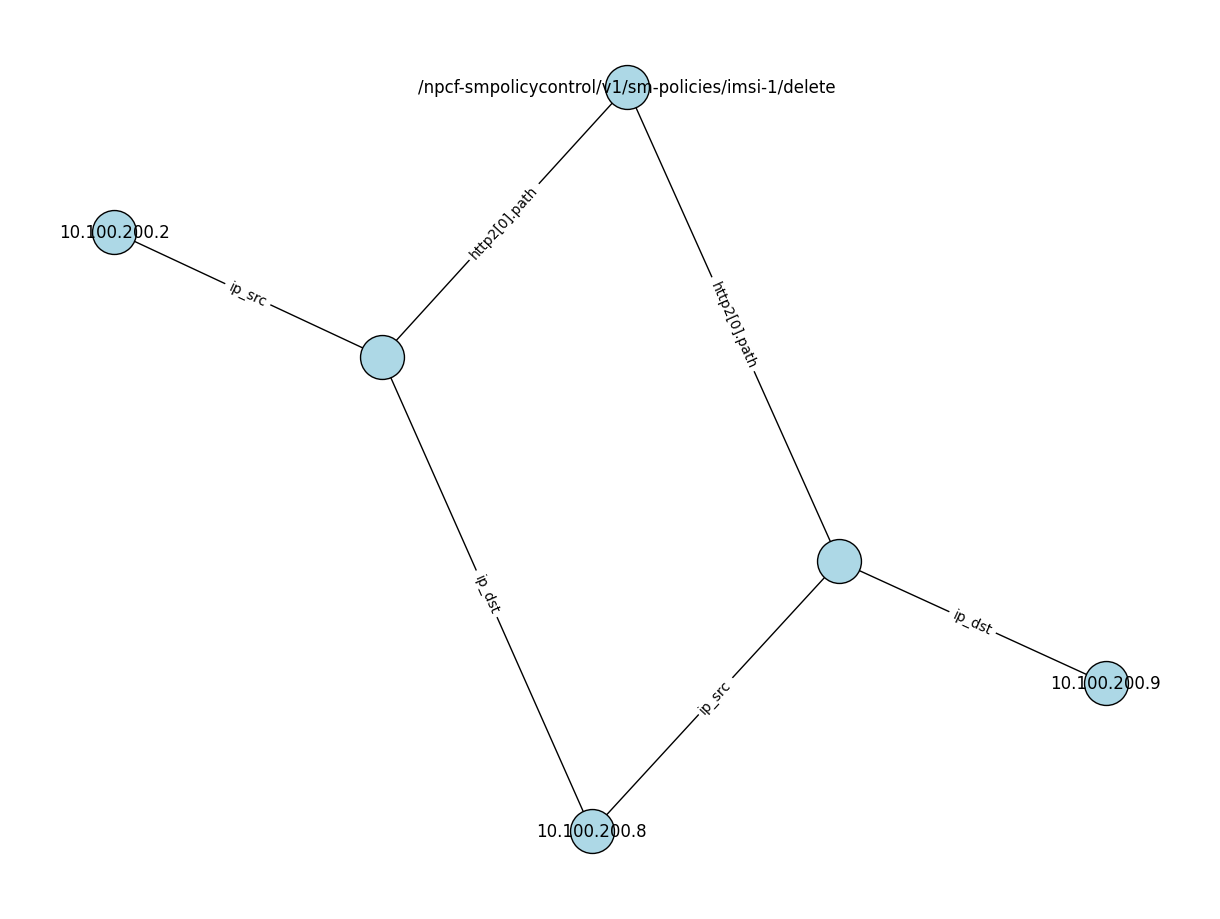

In [ ]:

import networkx as nx
import matplotlib.pyplot as plt

mitm_matches_unpack = []
for i in range(1):
    mitm_matches_unpack += list(mitm_matches[i])
mitm_matches_unpack = list(set(mitm_matches_unpack))

subG = graph.subgraph(list(mitm_matches_unpack)).copy()  # .copy() pour rendre le sous-graphe modifiable
plt.figure(figsize=(4*3,3*3))

node_labels = {n: subG.nodes[n].get("label", str(n)) for n in subG.nodes()}
edge_labels = nx.get_edge_attributes(subG, "label")

pos = nx.spring_layout(subG)  # ou kamada_kawai_layout, shell_layout, etc.
nx.draw(subG, pos, labels=node_labels, with_labels=True, node_color='lightblue', edgecolors='black', node_size=1000)
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels)
plt.show()

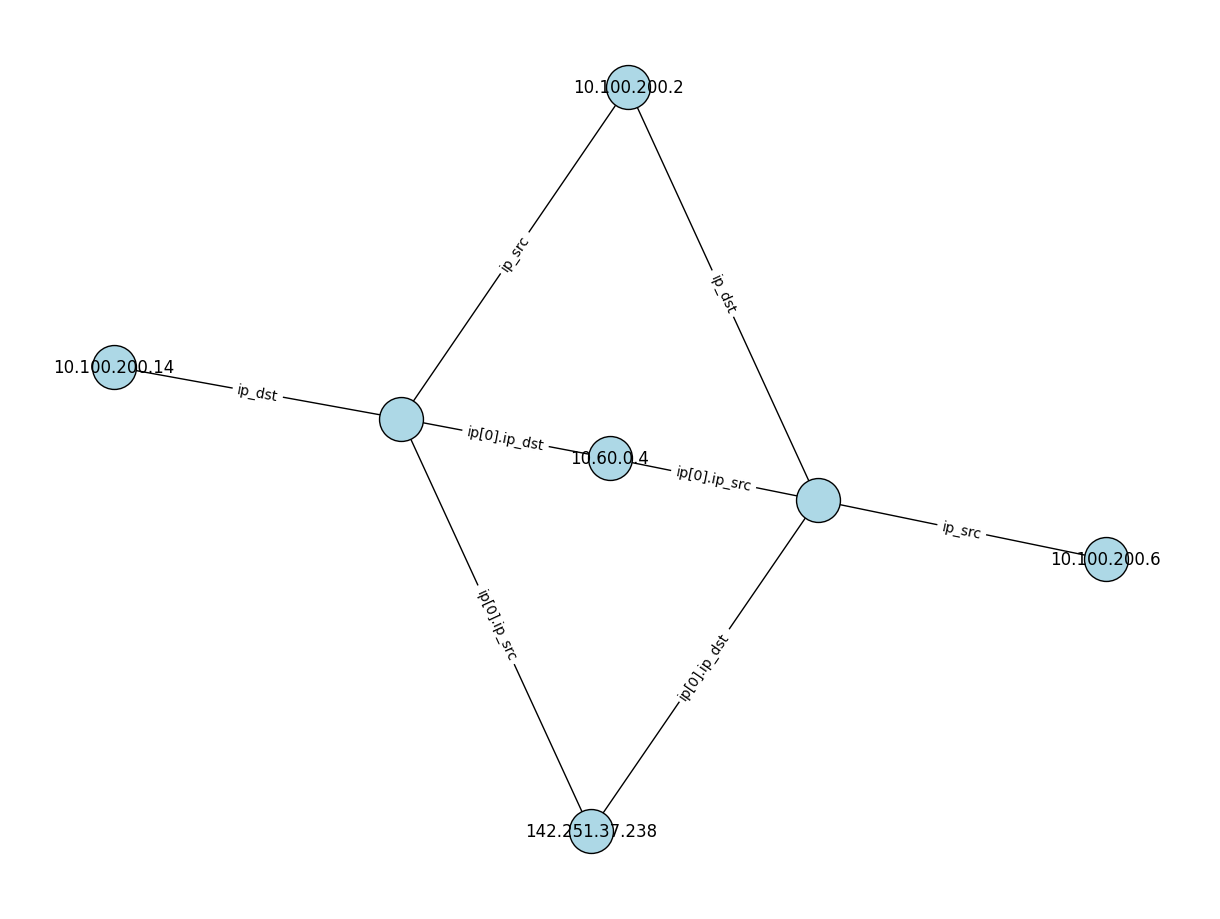

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

subG = graph.subgraph(list(uplink_matches[0])).copy()  # .copy() pour rendre le sous-graphe modifiable
plt.figure(figsize=(4*3,3*3))

node_labels = {n: subG.nodes[n].get("label", str(n)) for n in subG.nodes()}
edge_labels = nx.get_edge_attributes(subG, "label")

pos = nx.spring_layout(subG)  # ou kamada_kawai_layout, shell_layout, etc.
nx.draw(subG, pos, labels=node_labels, with_labels=True, node_color='lightblue', edgecolors='black', node_size=1000)
nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels)
plt.show()